Winner: 4
Eliminated: 
['47', '6', '3', '5', '2', '1']
**********************
Winner-only losers: 
[('3', {'2'}), ('6', {'5'}), ('47', {'3', '5', '4', '1', '2'})]
Building tree 
47
{'6', '3', '5', '1', '4', '2'}
*******
Building tree 
6
{'47', '3', '5', '1', '4', '2'}
*******
Building tree 
3
{'6', '47', '5', '1', '4', '2'}
*******
Building tree 
5
{'6', '47', '3', '1', '4', '2'}
*******
Building tree 
2
{'6', '47', '3', '5', '1', '4'}
*******
Building tree 
1
{'6', '47', '3', '5', '4', '2'}
*******
Built 
6
 trees.


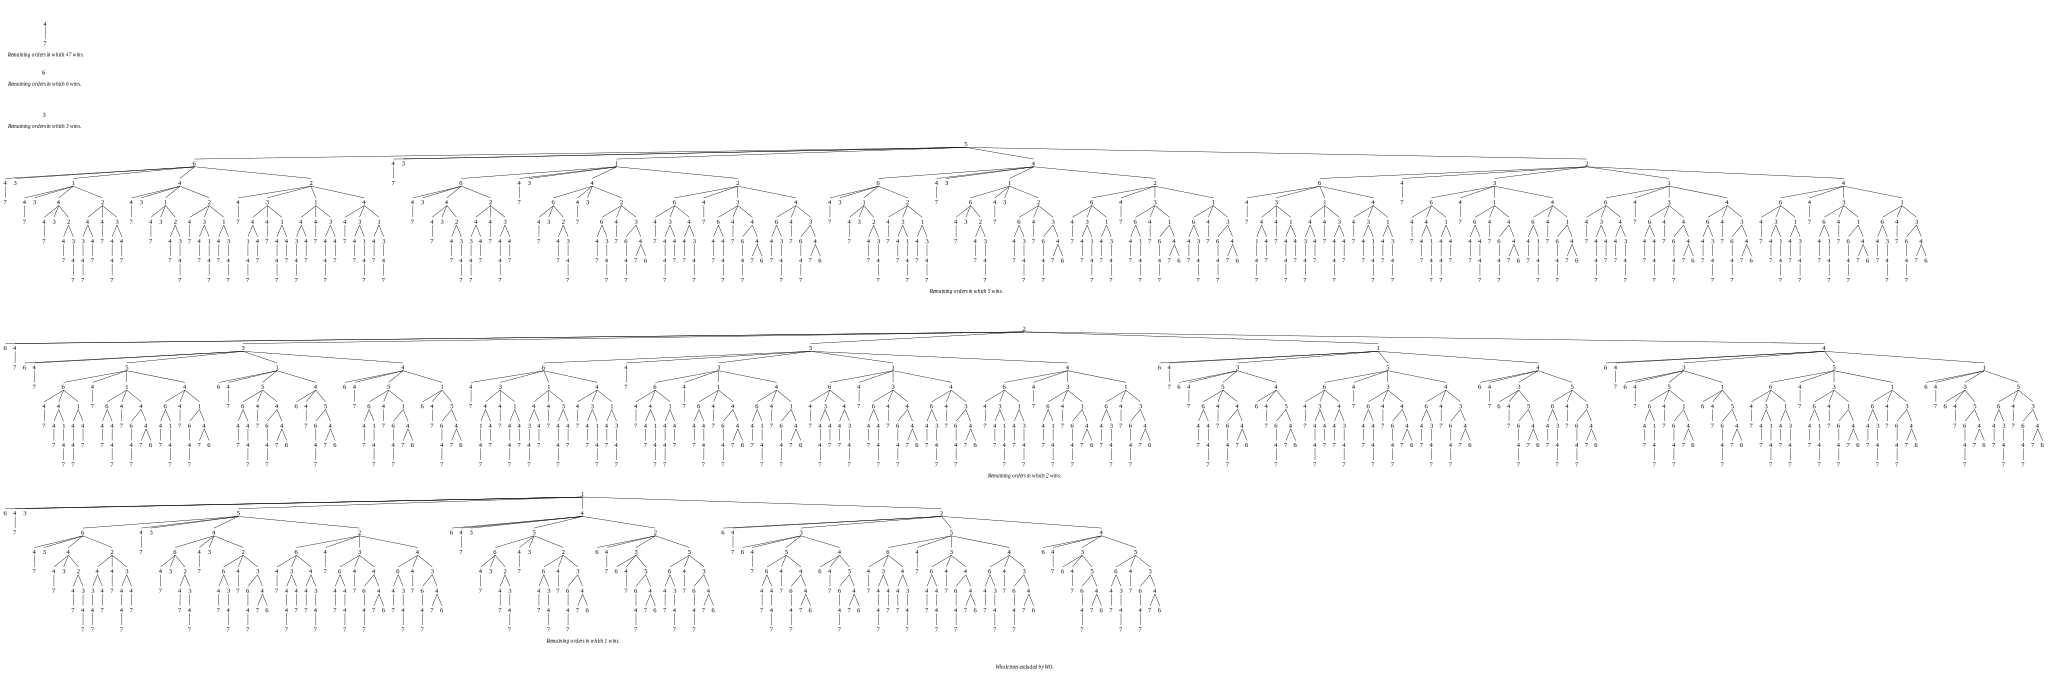

In [9]:
import json
import svgling
from svgling.figure import Caption, SideBySide, RowByRow
a_file = open("../AssertionJSON/RAIRE_sample_audit1.json")
auditfile = json.load(a_file)
apparentWinner = auditfile["Audits"][0]["Winner"]
print("Winner: "+apparentWinner)
apparentNonWinners=auditfile["Audits"][0]["Eliminated"]
print("Eliminated: ")
print(apparentNonWinners)
assertions = auditfile["Audits"][0]["Assertions"]
print("**********************")
WOLosers = list()

# WOLosers is a set of tuples - the first element of the tuple is the loser,
# the second element is a list of all the candidates it loses wrt.
# WOLosers = list()
for a in assertions:
    if a["Winner-Only"]=="true":
        l = a["Loser"]
        w = a["Winner"]
        # if we haven't already encountered this loser, add a new element to WOLosers.
        # if we have, add a new winner to this loser's set.
        losers = [ll for ll,_ in WOLosers]
        if l not in losers:
            #if l not in [losers[0] for losers in WOLosers]
            WOLosers.append((l,set(w)))
        else:
            for losers in WOLosers:
                if l == losers[0]:
                    losers[1].add(w)
            
# print(a)
print("Winner-only losers: ")
print(WOLosers)

# This takes a root candidate c and a set S of candidates still to
# be built in to the tree (i.e. those to be eliminated earlier, closer to the leaves)
# it checks whether c is winner-only dominated by any candidate in S and, if so,
# prunes the tree here.
def buildRemainingTreeAsLists(c,S):
    if c in S:
        print("Oops c is in S.  c = ")
        print(c)
        print(" S = ")
        print(S)
    # if S is empty, return the leaf
    if not S:
        return [c]
    # else if c in [ll for ll,_ in WOLosers]:

    # if c is a loser defeated by a candidate in S, prune here.
    for loser in WOLosers:
        if c==loser[0] and ((loser[1] & S)):
            return [c]
    
    tree=[c,[]]
    for c2 in S:
        smallerSet = S.copy()
        smallerSet.remove(c2)
        tree[1].append(buildRemainingTreeAsLists(c2,smallerSet))
    
    return tree
        
# Obviously this is not the right logic for drawing the tree.  I realise that I need to parse a little
# more carefully because the recursive step needs to know whether the candidates below are the ones that
# dominate c
def treeListToTuple(t):
    # If t is an empty list, we shouldn't have got this far
    if not t:
        print("Error: empty list in tree drawing")
    # Leaf
    if len(t) == 1:
        return(tuple(t[0]))
    else:
        tList = list(t[0])
        for branch in t[1]:
            tList.append(treeListToTuple(branch))
        return tuple(tList)
    
    #t = svgling.draw_tree((c))
    #if c in WOLosers:
    #    t.box_constituent((),fill="green")
    #    return t
    # Insert clever recursive logic for the case when c is not in WOLosers
    #return t
  

elimTrees=[]
for c in apparentNonWinners:
    candidateSet=set(apparentNonWinners).copy()
    candidateSet.add(apparentWinner)
    candidateSet.remove(c)
    treeAsLists=buildRemainingTreeAsLists(c,candidateSet)
    print("Building tree ")
    print(c)
    print(candidateSet)
    treeAsTuples=treeListToTuple(treeAsLists)
    drawnTree = svgling.draw_tree(treeAsTuples)
    Caption(drawnTree,"Remaining orders in which "+c+" wins.")
    print("*******")
    elimTrees.append(Caption(drawnTree,"Remaining orders in which "+c+" wins."))



#qrtree3 = ("Desert", ("Alpine", ("Beach", "Canyon"), ("Canyon", "Beach")),("Beach", ("Alpine", "Canyon"), ("Canyon", "Alpine")),("Canyon", ("Alpine", "Beach"), ("Beach", "Alpine")))
#out3 = svgling.draw_tree(qrtree3)
#Don't know how to print an arbitrary number of trees.
#Caption(SideBySide(elimTrees[0],elimTrees[1]), "Whole trees excluded by WO.")

print("Built ")
print(len(elimTrees))
print(" trees.")
print("Warning: hardcoded to print 6 trees!")

Caption(RowByRow(RowByRow(RowByRow(elimTrees[0],elimTrees[1]),RowByRow(elimTrees[2],elimTrees[3])),RowByRow(elimTrees[4],elimTrees[5])   ), "Whole trees excluded by WO.")



# RAIRE example assertions

This notebook provides a simple example of the kinds of assertions RAIRE might derive.
Suppose we have the following IRV CVRs:
- 10 votes list (Alpine, Beach, Canyon)
- 10 votes list (Alpine, Beach, Desert)
- 25 votes list (Beach)
- 6  votes list (Canyon, Alpine, Beach)
- 4  votes list (Desert, Alpine, Beach)
The apparent winner is Alpine, with apparent elimination order Desert, Canyon, Beach, (Alpine), shown below in red.
The audit needs to exclude all the other possible winners, though we don't care about other elimination orders in which Alpine wins.  To see how this works, click in each python box (including the import box above) and press shift-enter, working down the page.

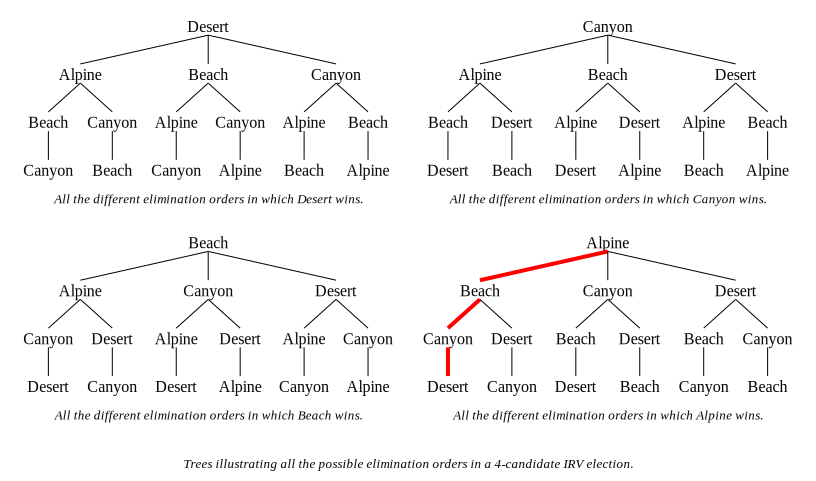

In [17]:
qrtree0 = ("Alpine", ("Beach", ("Canyon", "Desert"), ("Desert", "Canyon")),("Canyon", ("Beach", "Desert"), ("Desert", "Beach")),("Desert", ("Beach", "Canyon"), ("Canyon", "Beach")))
out0 = svgling.draw_tree(qrtree0)
out0.set_edge_style((0,), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out0.set_edge_style((0,0), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out0.set_edge_style((0,0,0), svgling.core.EdgeStyle(stroke_width=4, stroke="red"))
out0 = Caption(out0, "All the different elimination orders in which Alpine wins.")

qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),("Canyon", ("Alpine", "Desert"), ("Desert", "Alpine")),("Desert", ("Alpine", "Canyon"), ("Canyon", "Alpine")))
out1 = svgling.draw_tree(qrtree1)
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon", ("Alpine", ("Beach", "Desert"), ("Desert", "Beach")),("Beach", ("Alpine", "Desert"), ("Desert", "Alpine")),("Desert", ("Alpine", "Beach"), ("Beach", "Alpine")))
out2 = svgling.draw_tree(qrtree2)
out2 = Caption(out2, "All the different elimination orders in which Canyon wins.")

qrtree3 = ("Desert", ("Alpine", ("Beach", "Canyon"), ("Canyon", "Beach")),("Beach", ("Alpine", "Canyon"), ("Canyon", "Alpine")),("Canyon", ("Alpine", "Beach"), ("Beach", "Alpine")))
out3 = svgling.draw_tree(qrtree3)
out3 = Caption(out3, "All the different elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), SideBySide(out1,out0)), "Trees illustrating all the possible elimination orders in a 4-candidate IRV election.")

From now on we disregard the tree in which Alpine wins, and try to exclude all the others.  First consider Winner-only (WO) comparison between Alpine and Canyon - WO(Canyon,Alpine).  Canyon has only 6 mentions (not counting votes that prefer Alpine).  That's less than Alpine's first preference count of 20.  So Alpine cannot be eliminated before Canyon.

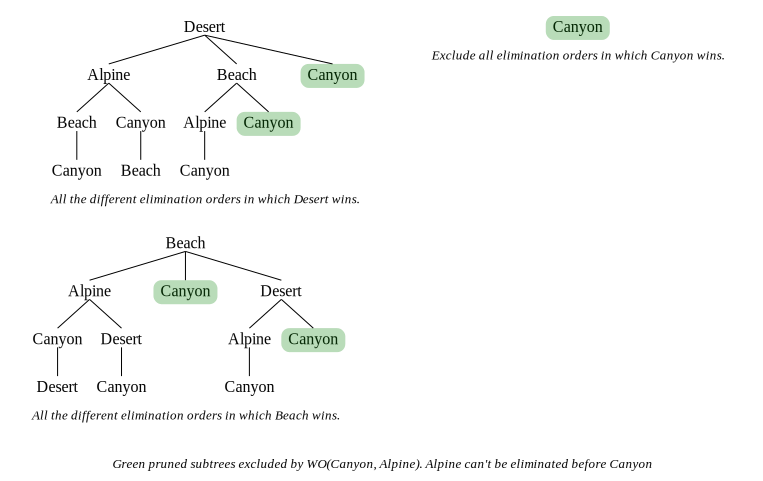

In [7]:
qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),"Canyon",("Desert", ("Alpine", "Canyon"), "Canyon"))
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,1),fill="green")
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert", ("Alpine", ("Beach", "Canyon"), ("Canyon", "Beach")),("Beach", ("Alpine", "Canyon"),"Canyon"),"Canyon")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((2,),fill="green")
out3.box_constituent((1,1),fill="green")
out3 = Caption(out3, "All the different elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Green pruned subtrees excluded by WO(Canyon, Alpine).  Alpine can't be eliminated before Canyon")

Now consider Winner-only (WO) comparison between Alpine and Desert - WO(Desert,Alpine).  Desert has only 4 mentions (not counting votes that prefer Alpine).  That's less than Alpine's first preference count of 20.  So Alpine cannot be eliminated before Desert.

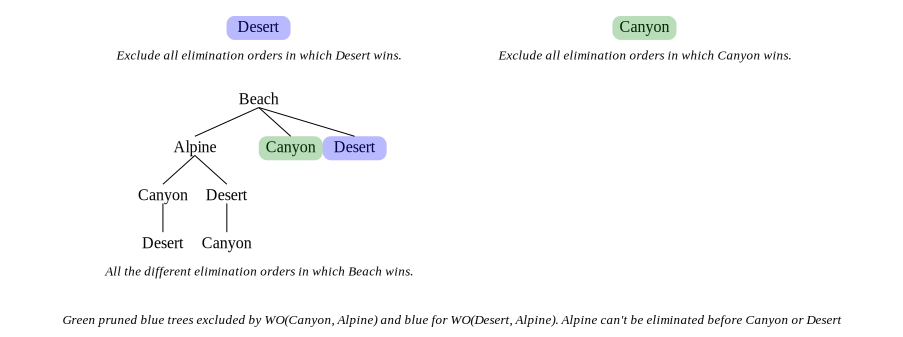

In [8]:
qrtree1 = ("Beach", ("Alpine", ("Canyon", "Desert"), ("Desert", "Canyon")),"Canyon","Desert")
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,),fill="blue")
out1 = Caption(out1, "All the different elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((),fill="blue")
out3 = Caption(out3, "Exclude all elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Green pruned blue trees excluded by WO(Canyon, Alpine) and blue for WO(Desert, Alpine).  Alpine can't be eliminated before Canyon or Desert")

Finally, WO(Beach,Alpine) doesn't work, because Beach has 25 mentions.  We need to test the last IRV round and compare only Beach, Alpine. This is written as IRV(Beach, Alpine, {Alpine}).

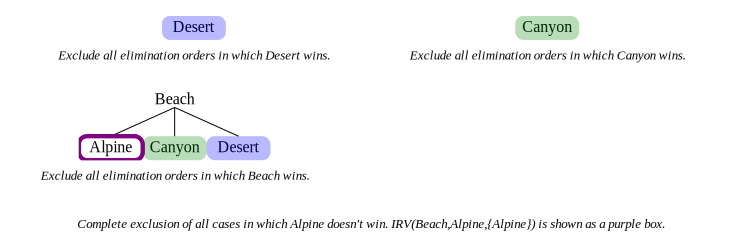

In [10]:
qrtree1 = ("Beach","Alpine","Canyon","Desert")
out1 = svgling.draw_tree(qrtree1)
out1.box_constituent((0,),fill="none",stroke_width=4, stroke="purple")
out1.box_constituent((1,),fill="green")
out1.box_constituent((2,),fill="blue")
out1 = Caption(out1, "Exclude all elimination orders in which Beach wins.")

qrtree2 = ("Canyon")
out2 = svgling.draw_tree(qrtree2)
out2.box_constituent((),fill="green")
out2 = Caption(out2, "Exclude all elimination orders in which Canyon wins.")

qrtree3 = ("Desert")
out3 = svgling.draw_tree(qrtree3)
out3.box_constituent((),fill="blue")
out3 = Caption(out3, "Exclude all elimination orders in which Desert wins.")

Caption(RowByRow(SideBySide(out3, out2), out1), "Complete exclusion of all cases in which Alpine doesn't win.  IRV(Beach,Alpine,{Alpine}) is shown as a purple box.")

Now the auditing begins!  We use Risk Limiting Audits to test all three assertions: WO(Canyon,Alpine), WO(Desert,Alpine) and IRV(Beach, Alpine, {Alpine}) simultaneously.